In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from encoding_function import low_frequency_to_others

import warnings
warnings.filterwarnings('ignore')

In [3]:
# from ctgan import CTGAN
# import random
# 
# data = pd.DataFrame({
#     'age': [25, 45, 35, 50, 23, 36, 29, 42, 58, 33],
#     'income': [50000, 100000, 75000, 110000, 48000, 60000, 52000, 90000, 120000, 70000],
#     'gender': ['M', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'F'],
#     'purchased': [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]  # 이것이 target 값이라고 가정
# })
# 
# random.seed(42)
# np.random.seed(42)
# # CTGAN 모델 생성
# # ctgan = CTGAN(epochs=100, verbose=True)
# 
# # 모델 학습 (target도 다른 변수와 함께 사용됨)
# # ctgan.fit(data, discrete_columns=['gender', 'purchased'])
# 
# # 새로운 데이터 생성
# new_data = ctgan.sample(10)
# display(new_data)

### 데이터 불러오기
- 학습: 2023년도 이전
- 검증: 2023년
- 테스트: 2024년

In [4]:
def add_y(df):
    df['rank'] = df['rank'].replace(0, 6)

    target_cols = [
        '단승', '복승', '삼복승'
    ]
    for i, col in enumerate(target_cols):
        condition_target = df['rank'] <= i+1
        df.loc[condition_target, col] = 1

    df[target_cols] = df[target_cols].fillna(0)
    df.drop(['rank'], axis=1, inplace=True)
    return df


ROOT_DIR = "data"
RANDOM_STATE = 999

train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

train = add_y(train)
test = add_y(test)

print(train.shape, test.shape)

(57474, 45) (5856, 45)


## 사용하지 않는 feature drop

- 전일 성적을 어떻게 반영할지

In [5]:
def drop_columns_from_datasets(df):
    drop_cols = [
        '연도', '회차', '일차', '경주번호',
        '금일출주경주',
        '모터번호', '전탑승선수1', '전탑승선수2',
        '보트번호', '특이사항',
        '전일성적'
    ]

    df = df.drop(drop_cols, axis=1)

    return df


train = drop_columns_from_datasets(train)
test = drop_columns_from_datasets(test)

print(train.shape, test.shape)

(57474, 34) (5856, 34)


## 일부 숫자형 변수 변환

- 코스별 성적/경기수 분리

In [6]:
def separation_course(df):
    col_list = [
        '코스_1코스', '코스_2코스', '코스_3코스', '코스_4코스', '코스_5코스', '코스_6코스'
    ]
    for col in col_list:
        df[[f'{col[3:]}_성적', f'{col[3:]}_경기수']] = df[col].fillna('').str.split('/', expand=True)

    df.drop(col_list, axis=1, inplace=True)

    return df
        


train = separation_course(train)
test = separation_course(test)

print(train.shape, test.shape)

(57474, 40) (5856, 40)


- 코스별 성적 스무딩

In [7]:
def apply_laplace_smoothing(df, col, global_mean, alpha):
    # 경기수 0인 값이 너무 높게 나오는 경향이 있어 분모에 상수 1 추가(없애도 됨)
    encoded_value = (df[f'{col}_성적'] * df[f'{col}_경기수'] + global_mean * alpha) / (1 + df[f'{col}_경기수'] + alpha)
    df[f'{col}_성적'] = encoded_value

    return df

def laplace_smoothing_to_course(train, val=None, alpha=1):
    col_list = [
        '1코스', '2코스', '3코스', '4코스', '5코스', '6코스'
    ]
    for col in col_list:
        train[f'{col}_성적'] = train[f'{col}_성적'].astype(float)
        train[f'{col}_경기수'] = train[f'{col}_경기수'].astype(float)
        if val is not None:
            val[f'{col}_성적'] = val[f'{col}_성적'].astype(float)
            val[f'{col}_경기수'] = val[f'{col}_경기수'].astype(float)

    # Train 데이터에서 글로벌 평균 계산
    global_means = {col: train[f'{col}_성적'].mean() for col in col_list}

    for col in col_list:
        # Train 데이터에 라플라스 스무딩 적용
        train = apply_laplace_smoothing(train, col, global_means[col], alpha)
        train.drop(f'{col}_경기수', axis=1, inplace=True)

    if val is not None:
        for col in col_list:
            # Validation 데이터에 Train에서 구한 글로벌 평균으로 라플라스 스무딩 적용
            val = apply_laplace_smoothing(val, col, global_means[col], alpha)
            val.drop(f'{col}_경기수', axis=1, inplace=True)

    if val is not None:
        return train, val
    else:
        return train


train, test = laplace_smoothing_to_course(train, test, alpha=1) # 알파가 작을수록 빈도수에 가깝세, 알파가 클수록 전체 평균에 가깝게
print(train.shape, test.shape)

(57474, 34) (5856, 34)


- 최근 8경기 착순 분리

- 최근 8경기를 어떻게 반영할지

In [8]:
def split_last_eight_rank(df):
    for i in range(0, 4):
        df[f'최근{i+1}경기_착순'] = df['최근8경주_착순'].str[i]
    for j in range(5, 9):
        df[f'최근{j}경기_착순'] = df['최근8경주_착순'].str[j]
        
    df.drop('최근8경주_착순', axis=1, inplace=True)
        
    return df

def adjust_for_top3(df):
    col_list = [
        '최근1경기_착순', '최근2경기_착순', '최근3경기_착순', '최근4경기_착순',
        '최근5경기_착순', '최근6경기_착순', '최근7경기_착순', '최근8경기_착순'
    ]
    
    for col in col_list:
    # 순위가 1, 2, 3이 아닌 경우, 결측인 경우, 6으로 조정
    # (일반화된 성능을 위해 + 3등내에 드는게 중요)
        df[col] = df[col].apply(lambda x: x if x in ['1', '2', '3'] else '-1')

    return df


train = split_last_eight_rank(train)
train = adjust_for_top3(train)

test = split_last_eight_rank(test)
test = adjust_for_top3(test)

print(train.shape, test.shape)

(57474, 41) (5856, 41)


## 범주형 변수 확인


In [9]:
def cal_cat_cols(train, val=None):
    objective_cols = []

    # 특정 문자열이 포함된 열을 범주형 변수로 지정
    cat_kerword_list = ['번호', '기수', '경기_착순', 'Race_ID']
    for col in train.columns:
        if any(sub in col for sub in cat_kerword_list):
            objective_cols.append(col)
            train[col] = train[col].astype('str')
            val[col] = val[col].astype('str')

    # 나머지 열에 대해 숫자형 변환 시도
    for col in train.columns:
        if col in objective_cols:
            continue  # 이미 범주형으로 처리된 열은 제외
        try:
            # 'float' 타입으로 변환 시도
            train[col] = train[col].astype('float')
            val[col] = val[col].astype('float')
        except:
            objective_cols.append(col)

    cat_features = list(set(objective_cols) - set(['rank', 'Race_ID']))

    return cat_features


# cat_features = cal_cat_cols(train, test)
# cat_features

- 낮은 빈도 데이터 통합

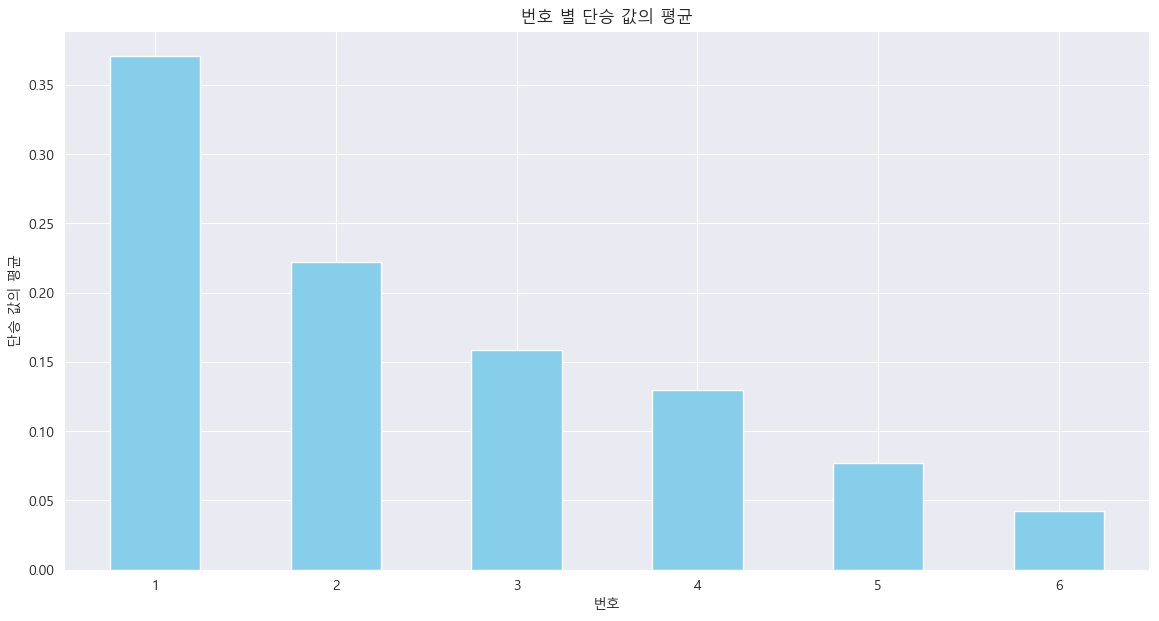

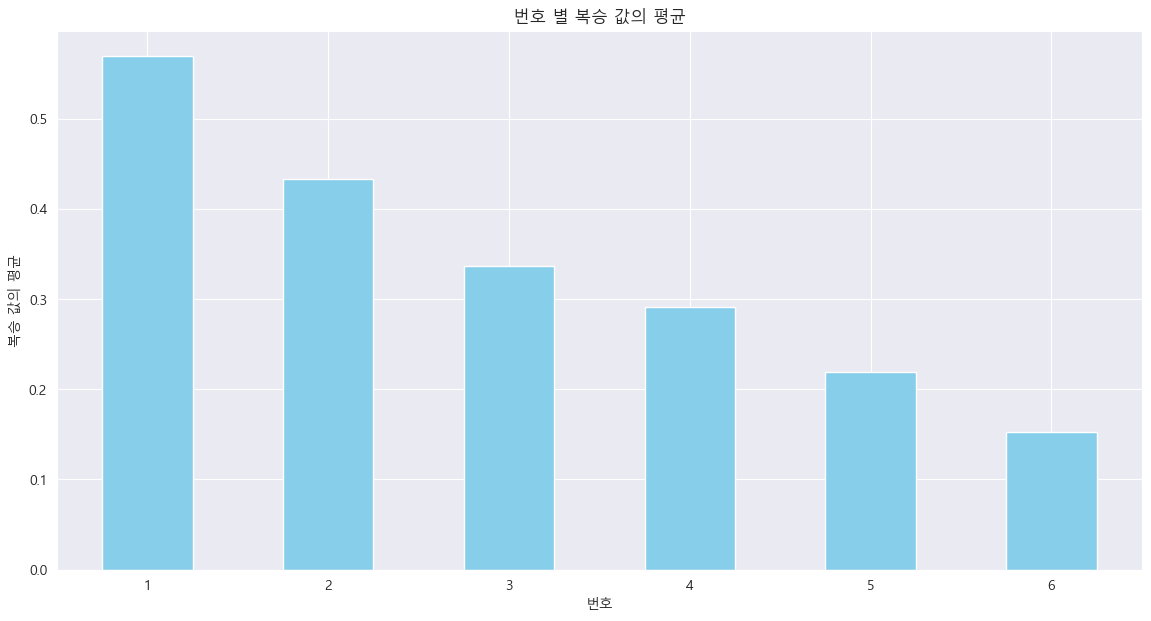

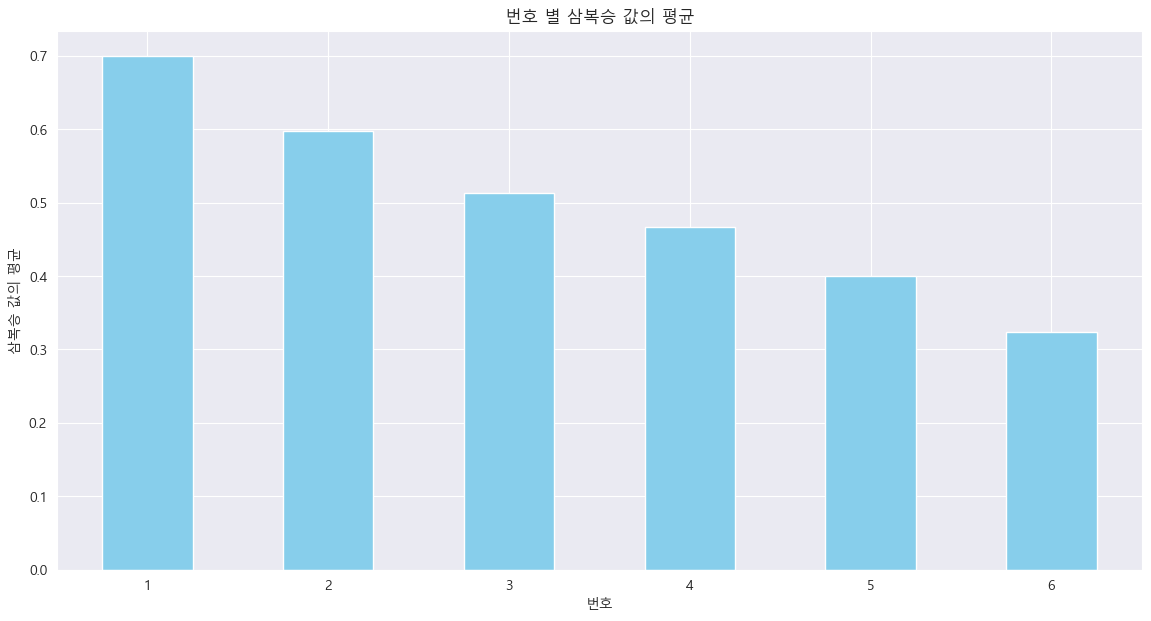

In [10]:
plt.rcParams['font.family'] = 'Malgun Gothic'

cols = [
    '단승', '복승', '삼복승'
]

for col in cols:
    mean_values = train.groupby('번호')[col].mean()
    
    plt.figure(figsize=(14, 7))
    mean_values.plot(kind='bar', color='skyblue')
    plt.title(f'번호 별 {col} 값의 평균')
    plt.xlabel('번호')
    plt.ylabel(f'{col} 값의 평균')
    plt.xticks(rotation=0)
    plt.show()

## X, y 분리

In [11]:
drop_cols = [
    'Race_ID', '번호', '단승', '복승', '삼복승'
]

X_train = train.drop(drop_cols, axis=1)
y_train = train[['단승']]
X_test = test.drop(drop_cols, axis=1)
y_test = test[['단승']]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(57474, 36) (57474, 1) (5856, 36) (5856, 1)


In [12]:
def reshape_race_data(df, players_per_race=6):
    # numpy 배열로 변환
    values = df.values

    # 데이터 형태 변환 (6개의 행을 1개의 행으로)
    reshaped_values = values.reshape(-1, players_per_race * values.shape[1])

    # 새로운 컬럼 이름 생성
    columns = [f'{col}_{i+1}번선수' for i in range(players_per_race) for col in df.columns]

    # 재구성된 DataFrame 생성
    reshaped_df = pd.DataFrame(reshaped_values, columns=columns)

    return reshaped_df

X_train = reshape_race_data(X_train, players_per_race=6)
y_train = reshape_race_data(y_train, players_per_race=6)
y_train = np.array(y_train).astype(int)

X_test = reshape_race_data(X_test, players_per_race=6)
y_test = reshape_race_data(y_test, players_per_race=6)
y_test = np.array(y_test).astype(int)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9579, 216) (9579, 6) (976, 216) (976, 6)


In [13]:
def low_to_others(train, val, threshold=5, verbose=False):
    cat_features = cal_cat_cols(train, val)

    for col in cat_features:
        unifier = low_frequency_to_others(threshold=threshold, verbose=verbose)
        train[col] = unifier.fit_transform(train[col])
        val[col] = unifier.transform(val[col])

    return train, val

X_train, X_test = low_to_others(X_train, X_test, threshold=10, verbose=True)

Columns:(기수_6번선수) 변환 X
Columns:(기수_6번선수) 'others'로 8개 변환
Columns:(등급_5번선수) 변환 X
Columns:(등급_5번선수) 변환 X
Columns:(최근4경기_착순_1번선수) 변환 X
Columns:(최근4경기_착순_1번선수) 변환 X
Columns:(최근5경기_착순_1번선수) 변환 X
Columns:(최근5경기_착순_1번선수) 변환 X
Columns:(최근6경기_착순_4번선수) 변환 X
Columns:(최근6경기_착순_4번선수) 변환 X
Columns:(기수_5번선수) 변환 X
Columns:(기수_5번선수) 'others'로 8개 변환
Columns:(최근8경기_착순_5번선수) 변환 X
Columns:(최근8경기_착순_5번선수) 변환 X
Columns:(최근2경기_착순_2번선수) 변환 X
Columns:(최근2경기_착순_2번선수) 변환 X
Columns:(성별_5번선수) 변환 X
Columns:(성별_5번선수) 변환 X
Columns:(최근3경기_착순_4번선수) 변환 X
Columns:(최근3경기_착순_4번선수) 변환 X
Columns:(최근7경기_착순_1번선수) 변환 X
Columns:(최근7경기_착순_1번선수) 변환 X
Columns:(등급_4번선수) 변환 X
Columns:(등급_4번선수) 변환 X
Columns:(최근5경기_착순_3번선수) 변환 X
Columns:(최근5경기_착순_3번선수) 변환 X
Columns:(성별_4번선수) 변환 X
Columns:(성별_4번선수) 변환 X
Columns:(최근7경기_착순_2번선수) 변환 X
Columns:(최근7경기_착순_2번선수) 변환 X
Columns:(최근8경기_착순_4번선수) 변환 X
Columns:(최근8경기_착순_4번선수) 변환 X
Columns:(성별_1번선수) 변환 X
Columns:(성별_1번선수) 변환 X
Columns:(최근7경기_착순_3번선수) 변환 X
Columns:(최근7경기_착순_3번선수) 변환 X
Columns:(등급_1번선수) 

In [19]:
def all_precoess(train, val, target='단승', is_train=True):
    train = add_y(train)
    val = add_y(val)
    
    train = drop_columns_from_datasets(train)
    val = drop_columns_from_datasets(val)

    train = separation_course(train)
    val = separation_course(val)

    train, val = laplace_smoothing_to_course(train, val, alpha=1)

    train = split_last_eight_rank(train)
    train = adjust_for_top3(train)
    
    val = split_last_eight_rank(val)
    val = adjust_for_top3(val)

    # train, val = low_to_others(train, val, threshold=10, verbose=False)

    drop_cols = [
        'Race_ID', '번호', '단승', '복승', '삼복승', '선수명', '기수'
    ]
    X_train = train.drop(drop_cols, axis=1)
    y_train = train[[target]]
    X_val = val.drop(drop_cols, axis=1)
    y_val = val[[target]]

    X_train = reshape_race_data(X_train, players_per_race=6)
    y_train = reshape_race_data(y_train, players_per_race=6)
    y_train = np.array(y_train).astype(int)

    X_val = reshape_race_data(X_val, players_per_race=6)
    y_val = reshape_race_data(y_val, players_per_race=6)
    y_val = np.array(y_val).astype(int)

    X_train, X_val = low_to_others(X_train, X_val, threshold=5, verbose=False)
    
    return X_train, y_train, X_val, y_val

train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

target_value='단승'
X_train, y_train, X_test, y_test = all_precoess(train, test, target=target_value, is_train=True)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9579, 204) (9579, 6) (976, 204) (976, 6)


In [25]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

class custom_CatBoostClassifier():
    def __init__(self, params):
        self.models = [CatBoostClassifier(**params) for _ in range(6)]

    def fit(self, X, y, eval_set=None, cat_features=None):
        y = np.array(y)  # y를 numpy 배열로 변환
        if eval_set is not None:
            X_val, y_val = eval_set
            y_val = np.array(y_val)  # y_val을 numpy 배열로 변환

        for i in range(6):
            y_i = y[:, i]  # i번째 레이블에 대한 y 값

            if eval_set is not None:
                y_val_i = y_val[:, i]  # i번째 레이블에 대한 y_val 값
                eval_set_i = (X_val, y_val_i)
            else:
                eval_set_i = None

            self.models[i].fit(
                X, y_i,
                eval_set=eval_set_i,
                cat_features=cat_features
            )
            print(f'{i+1}번째 레이블 학습 완료')

    def predict(self, X):
        preds = [model.predict(X) for model in self.models]
        return np.vstack(preds).T

    def predict_proba(self, X):
        probas = [model.predict_proba(X)[:, 1] for model in self.models]
        return np.vstack(probas).T
    
    
params = {
    'random_seed': RANDOM_STATE,
    'iterations': 3000,
    'learning_rate': 0.05,
    'early_stopping_rounds': 100,
    'auto_class_weights': 'SqrtBalanced',
    'eval_metric': 'Accuracy',
    'verbose': 200,
    'thread_count':-1
}

model = custom_CatBoostClassifier(params)
cat_features = cal_cat_cols(X_train, X_test)
print(f'범주형 변수: {cat_features}')
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
)

범주형 변수: ['등급_5번선수', '최근4경기_착순_1번선수', '최근5경기_착순_1번선수', '최근6경기_착순_4번선수', '최근8경기_착순_5번선수', '최근2경기_착순_2번선수', '성별_5번선수', '최근3경기_착순_4번선수', '최근7경기_착순_1번선수', '등급_4번선수', '최근5경기_착순_3번선수', '성별_4번선수', '최근7경기_착순_2번선수', '최근8경기_착순_4번선수', '성별_1번선수', '최근7경기_착순_3번선수', '등급_1번선수', '최근8경기_착순_2번선수', '최근5경기_착순_4번선수', '성별_3번선수', '최근4경기_착순_5번선수', '최근2경기_착순_1번선수', '최근2경기_착순_6번선수', 'FL_5번선수', '성별_6번선수', '최근6경기_착순_5번선수', '최근3경기_착순_5번선수', '최근8경기_착순_6번선수', '최근1경기_착순_5번선수', 'FL_2번선수', '최근6경기_착순_6번선수', '최근5경기_착순_5번선수', '최근1경기_착순_1번선수', '최근4경기_착순_6번선수', '최근3경기_착순_2번선수', '최근6경기_착순_3번선수', '최근3경기_착순_6번선수', '최근1경기_착순_4번선수', '최근2경기_착순_5번선수', '등급_2번선수', '성별_2번선수', '최근7경기_착순_4번선수', 'FL_6번선수', '최근5경기_착순_6번선수', '최근5경기_착순_2번선수', '최근4경기_착순_3번선수', '최근7경기_착순_6번선수', '최근8경기_착순_1번선수', '최근2경기_착순_4번선수', '최근3경기_착순_1번선수', 'FL_1번선수', 'FL_4번선수', '최근8경기_착순_3번선수', '등급_6번선수', '최근4경기_착순_2번선수', '최근6경기_착순_1번선수', '최근6경기_착순_2번선수', 'FL_3번선수', '최근2경기_착순_3번선수', '최근4경기_착순_4번선수', '최근3경기_착순_3번선수', '최근1경기_착순_3번선수', '최근7경기_착순_5번선수', '최근1경기_착순_2번선수', '등급_3

In [26]:
# 모델 예측
y_pred = model.predict_proba(X_test)

y_pred_max = np.zeros_like(y_pred)
for i in range(y_pred.shape[0]):  # 각 샘플에 대해 반복
    if target_value=='단승':
        max_indices = np.argsort(y_pred[i])[-1:]  # 가장 큰 두 개의 값의 인덱스 찾기
    elif target_value=='복승':
        max_indices = np.argsort(y_pred[i])[-2:]
    elif target_value=='삼복승':
        max_indices = np.argsort(y_pred[i])[-3:]
    y_pred_max[i, max_indices] = 1  # 해당 인덱스에 1 설정

accuracy = accuracy_score(y_pred_max, y_test)
print(f'Val Accuracy: {accuracy}') # val 경기중, 23%는 모두 맞췄다는 의미

Val Accuracy: 0.45594262295081966


# 실제 경기 예측

In [27]:
# test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
# 
# target_value='단승'
# X_train, y_train, X_test, y_test = all_precoess(train, test, target=target_value, is_train=True)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [28]:
# # 모델 예측
# y_pred_test = model.predict_proba(X_test)
# 
# y_pred_max = np.zeros_like(y_pred_test)
# for i in range(y_pred_test.shape[0]):  # 각 샘플에 대해 반복
#     if target_value=='단승':
#         max_indices = np.argsort(y_pred_test[i])[-1:]  # 가장 큰 두 개의 값의 인덱스 찾기
#     elif target_value=='복승':
#         max_indices = np.argsort(y_pred_test[i])[-2:]
#     elif target_value=='삼복승':
#         max_indices = np.argsort(y_pred_test[i])[-3:]
#     y_pred_max[i, max_indices] = 1  # 해당 인덱스에 1 설정
# 
# 
# accuracy = accuracy_score(y_pred_max, y_test)
# print(f'Test Accuracy: {accuracy}')